In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from transformer import *
import os
%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'transformer'

In [ ]:
df = pd.read_excel('../Cas_D_Etude/Cas_Etude_Volcano/NE PAS OUVRIR/association_table_corrected_index.xlsx')

In [ ]:
df.head(5)

In [ ]:
import pickle

try:
    table = pd.read_pickle('../association_table.pkl')
except:
    table = pd.read_excel('../Cas_D_Etude/Cas_Etude_Volcano/NE PAS OUVRIR/association_table.xlsx')
    table.to_pickle("../Cas_Etude_Vulcano/association_table.pkl")

In [32]:
df=table

# Class Transformer 

In [28]:
# TACHE : empilement de pipelines avec l'aide d'une classe transformer qui:
#   - récupérer à partir des 2 1eres colonnes du fichier association_table_corrected_index.xlsx le nom du fichier numpy
#   - créer un chemin pour aller récupérer les données du fichier numpy

import pandas as pd
import numpy as np
import os
from sklearn.base import TransformerMixin
from pathlib import Path

class Transformer(TransformerMixin):

    def __init__(self, directory_path):
        self.directory_path = directory_path
#       directory_path : absolute path of the directory containing all folders of numpy files (until Extracted/)
#                        /!\ DO NOT FORGET TO END THE STRING BY THE CHARACTER '/'
    
    def get_event_and_file_name(self, catalog_file, index:int):
        """
        Input :
            - catalog_file : table associating the files with their information and indexes
            - index : index of the desired file row in the catalog_file
        Output : event associated with file, directory where the file is stored and string with the name of the file
        """
        list_of_file_directories = ['EXP','HIB','LP','PIS','TOR','TR','VT']
        event = catalog_file.loc[index,'Event']

        # on supprime le dernier caractère pour avoir le nom du dossier où est le fichier
        if event not in list_of_file_directories:
            event_without_last_digit = event[:-1]
            name = str(event_without_last_digit + '_' + str(index))
            return event_without_last_digit, name
        else:
            name = str(event + '_' + str(index))
            return event, name

    def put_event_in_df(self,catalog_file):
        """
        Input :
            - catalog_file : table associating the files with their information and indexes
        Output : creates a column in the dataframe for the type of event
        """
        for idx in catalog_file.index:
            try :
                event, name = self.get_event_and_file_name(catalog_file, idx)
                catalog_file.loc[idx, 'event'] = event
            except:
                pass
        return catalog_file
    
    def get_file_path(self, catalog_file, index):
        """
        Input :
            - catalog_file : table associating the files with their information and indexes
            - index : index of the desired file row in the catalog_file
        Output : return the relative path for the desired file
        """
        # on récupère le nom de l'event (dossier dans lequel est rangé le fichier) et du fichier
        event, name = self.get_event_and_file_name(catalog_file, index)
        
        # on crée un string pour avoir le chemin du fichier
        end_folder_path = str(event + '/' + name + '.npy')
        final_path = self.directory_path + end_folder_path
        return final_path
    
    def put_path_in_df(self, catalog_file):
        """
        Input :
            - catalog_file : table associating the files with their information and indexes
        Output : creates a column in the dataframe for the file path of each numpy file
        """
        for idx in catalog_file.index:
            try :
                path = self.get_file_path(catalog_file, idx)
                catalog_file.loc[idx, 'path'] = path
            except:
                pass
        return catalog_file

    def open_file(self, catalog_file, index):
        """
        Input :
            - catalog_file : table associating the files with their information and indexes
            - index : index of the desired file row in the catalog_file        
        Output : loads the file at the desired index
        """
        # on récupère le chemin menant au fichier
        path = self.get_file_path(catalog_file, index)
        
        if os.path.exists(path):
            file = np.load(path) # on ouvre le fichier seulement s'il existe
            return file
        else:
            pass
    
    def get_info_from_file(self, catalog_file, index):
        """
        Input : 
            - catalog_file : table associating the files with their information and indexes
            - index : index of the desired file row in the catalog_file        
        Output : Returns a tuple with the variance, mean, median, maximum and amplitude of the numpy array
        """
        try:
            data = self.open_file(catalog_file, index)
            variance = np.var(data)
            mean = np.mean(data)
            median = np.median(data)
            maximum = np.amax(data)
            minimum = np.amin(data)
            amplitude = maximum - minimum
            return variance, mean, median, maximum, amplitude
        except:
            pass
    
    def supp_columns(self, catalog_file, columns_to_supp=["File name","File start" ,"File end" ,"Unnamed: 10" ,"Unnamed: 11" ,"Unnamed: 12"]):
        """
        Input :
            - catalog_file : table associating the files with their information and indexes
            - columns_to_supp : list of columns names to delete from the dataframe catalog_file. If None, following
                                columns are deleted : ["File name","File start" ,"File end" ,"Unnamed: 10" ,"Unnamed: 11" ,"Unnamed: 12"] 
        Output : returns the dataframe catalog_file cleant from unused columns
        """
        catalog_file.drop(columns_to_supp, axis=1, inplace=True)
        return catalog_file
    
    def put_info_in_df(self, catalog_file):
        """
        Input :
            - catalog_file : table associating the files with their information and indexes
        Output : creates a different column for variance, mean, median, maximum and amplitude of each numpy array.
        """
        for idx in catalog_file.index:
            try :
                variance, mean, median, maximum, amplitude = self.get_info_from_file(catalog_file, idx)
                catalog_file.loc[idx, 'variance'] = variance
                catalog_file.loc[idx, 'mean'] = mean
                catalog_file.loc[idx, 'median'] = median
                catalog_file.loc[idx, 'maximum'] = maximum
                catalog_file.loc[idx, 'amplitude'] = amplitude
            except:
                pass
        return catalog_file

    def fit_transform(self, X):
        """
        Input :
            - X : array-like of shape (n_samples, n_features)
        Output : returns a fit_transformed X array
        """
        X_copy = X.copy()
        X_with_event = self.put_event_in_df(X_copy)
        X_with_path = self.put_path_in_df(X_with_event)
        X_supp_cols = self.supp_columns(X_with_path)
        X_add_cols = self.put_info_in_df(X_supp_cols)
        return X_add_cols


if __name__ == '__main__':
    print('class Transformer successfully imported')

class Transformer successfully imported


In [36]:
round(df.Event.value_counts()*100/len(df),2)

LP1    79.07
TR2    10.10
TR1     3.75
LPP     3.65
PIS     1.36
VT1     1.07
HIB     0.38
VTP     0.22
LP2     0.13
EXP     0.13
TOR     0.09
TRA     0.05
Name: Event, dtype: float64

In [47]:
round(df_transf.Event.value_counts()*100/len(df_transf),2)

TR2    52.56
LPP    20.10
TR1    14.17
PIS     7.35
HIB     2.23
VT1     1.54
LP2     0.71
EXP     0.71
TOR     0.50
VTP     0.10
TRA     0.02
Name: Event, dtype: float64

In [37]:
df_partiel=df[df.Event!='LP1']

In [38]:
path = "/home/d5learner-08/GDrive/Cas_D_Etude/Cas_Etude_Vulcano/NE PAS OUVRIR/Extracted/"
transfo = Transformer(path)

df_transf=transfo.fit_transform(df_partiel)

In [39]:
df_transf.to_pickle("../Cas_Etude_Vulcano/association_table_transfo.pkl")

In [44]:
df_transf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20285 entries, 2 to 124783
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Index          20285 non-null  int64  
 1   Event          20285 non-null  object 
 2   Duration       20285 non-null  int64  
 3   Event start    20285 non-null  object 
 4   Event stop     20285 non-null  object 
 5   Sampling rate  20285 non-null  float64
 6   Overlap        20285 non-null  bool   
 7   npts           20285 non-null  float64
 8   energy         20285 non-null  float64
 9   path           20285 non-null  object 
 10  event          20285 non-null  object 
 11  variance       20285 non-null  float64
 12  mean           20285 non-null  float64
 13  median         20285 non-null  float64
 14  maximum        20285 non-null  float64
 15  amplitude      20285 non-null  float64
dtypes: bool(1), float64(8), int64(2), object(5)
memory usage: 2.5+ MB


In [41]:
df_transf.head(5)

,Index,Event,Duration,Event start,Event stop,Sampling rate,Overlap,npts,energy,path,event,variance,mean,median,maximum,amplitude
2,2,TR2,128,2006-05-23 22:37:52.910000+00:00,2006-05-23 22:40:00.910000+00:00,50.0,False,90000.0,0.79052,/home/d5learner-08/GDrive/Cas_D_Etude/Cas_Etud...,TR,42986.019531,26.641539,27.549942,990.936279,1959.923828
4,4,TR2,78,2006-05-23 22:46:58.440000+00:00,2006-05-23 22:48:16.440000+00:00,100.0,False,60000.0,0.23330,/home/d5learner-08/GDrive/Cas_D_Etude/Cas_Etud...,TR,27451.826172,190.655899,207.000000,740.000000,1200.000000
23,23,TR2,120,2006-05-23 23:07:00.580000+00:00,2006-05-23 23:09:00.580000+00:00,50.0,False,150100.0,0.87245,/home/d5learner-08/GDrive/Cas_D_Etude/Cas_Etud...,TR,68384.156250,231.322540,224.151184,1353.595825,3030.478760
24,24,TR2,148,2006-05-23 23:12:23.640000+00:00,2006-05-23 23:14:51.640000+00:00,50.0,False,150100.0,0.70454,/home/d5learner-08/GDrive/Cas_D_Etude/Cas_Etud...,TR,44482.503906,154.392151,157.484436,1559.584229,2553.325928
25,25,TR2,73,2006-05-23 23:18:59.120000+00:00,2006-05-23 23:20:12.120000+00:00,100.0,False,60000.0,0.36044,/home/d5learner-08/GDrive/Cas_D_Etude/Cas_Etud...,TR,45587.742188,147.313705,145.000000,1095.000000,1947.000000


In [42]:
# gridsearch for the Random Forest classifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

df_transf.dropna(axis=0,how='any',inplace=True)

y=df_transf.event.copy()
X=df_transf[["Duration","energy", "mean", "median", "maximum",  "amplitude", "variance"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

k_range = [5,30,60,100]
param_grid =  {'n_estimators': k_range}

RF_clf=RandomForestClassifier()

# grid_search = GridSearchCV(RF_clf, param_grid, cv=3, scoring='recall') #'average_precision')
# grid_search.fit(X_train, y_train)

# print(grid_search.best_score_)
# print(grid_search.best_params_)

RF_clf.fit(X_train, y_train)


RandomForestClassifier()

In [43]:
RF_clf.score(X_test,y_test)

0.8523264984227129

In [ ]:
df_transf.E

%store df

%store -r df

614.3727


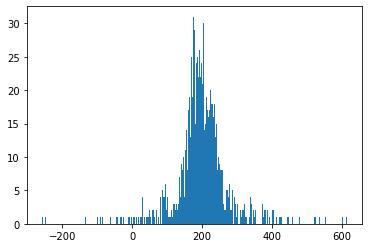

174.81664
Line2D(_line0)


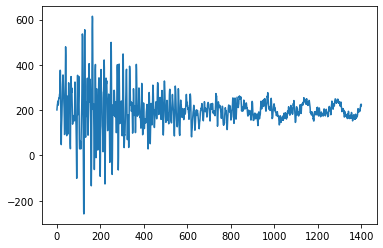

In [225]:

df_histo=plt.hist(np_VT_400,bins=500)
plt.show()   
maxi=np.max(df_histo[0]) 
l=df_histo[0].tolist()
i=l.index(maxi)
print(df_histo[1][i])
p=max(plt.plot(np_VT_400))
print(p)

In [ ]:
def TF_stat():
    
    T = df.loc[0,'Duration'] # Durée échantillonnage
    fe = df.loc[0,'Sampling rate']  # Freq échantionnage
    echantillons = np.load(df.loc[0,'path'])

    tfd = fft(echantillons)
    N=len(echantillons)
    spectre = np.absolute(tfd)*2/N
    #L'échelle des fréquences est construite sachant que l'espacement fréquentiel de deux points de la TFD est l'inverse de la durée T :
    freq=np.arange(N)*1.0/T

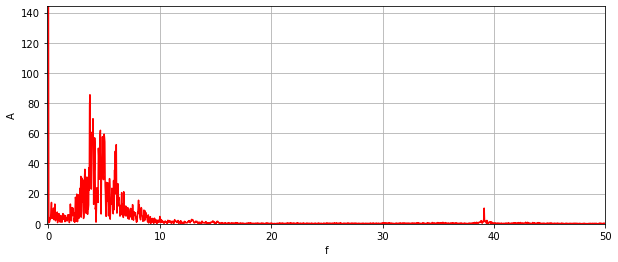

In [235]:
import math
import numpy as np
from matplotlib.pyplot import *
from numpy.fft import fft 
from scipy import fftpack

T = df.loc[0,'Duration'] # Durée échantillonnage
fe = df.loc[0,'Sampling rate']  # Freq échantionnage
echantillons = np.load(df.loc[0,'path'])

tfd = fft(echantillons)
N=len(echantillons)
spectre = np.absolute(tfd)*2/N
            

#L'échelle des fréquences est construite sachant que l'espacement fréquentiel de deux points de la TFD est l'inverse de la durée T :
freq=np.arange(N)*1.0/T
           
#On trace le spectre pour des fréquences allant de zéro à la moitié de la fréquence d'échantillonnage :

figure(figsize=(10,4))
plot(freq,spectre,'r')
xlabel('f')
ylabel('A')
axis([-0.1,fe/2,0,spectre.max()])
grid()


X = fftpack.fft(echantillons)   

